<a href="https://colab.research.google.com/github/karthikpuranik11/FIRE2021/blob/main/Tamil/Bert%2BbiLSTM_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1 MB 30.1 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 3.0 MB 35.5 MB/s 
     |████████████████████████████████| 1.2 MB 52.1 MB/s 


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train1=pd.read_csv('/content/tam_final.csv')
train1['labels']=LabelEncoder().fit_transform(train1['category'])
#train=train.drop(columns='label')
train1

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,text,category,trans,translate,labels
0,0,0,0,Vani bhojam fans hit like solli 500 like Vangi...,unknown_state,வாணி பூஜாம் பான்ஸ் ஹிட் லிக் சொல்லி 500 லிக் வ...,Vani Pujan Pans Hit Leak: Get 500 Leak Banks\n,5
1,1,1,1,I love you ajith very I like,Positive,ஐஸ் லோவ் யூ அஜித் வேரி ஐஸ் லிக்,Ice Love You Ajith very Ice Lick\n,2
2,2,2,2,ennaya trailer Ku mudi Ellam nikkudhu... Vera ...,Positive,எண்ணய டிரைலர் கூ முடி எல்லம் நிக்குது... வேற ல...,The oil trailer has all the hair and the trail...,2
3,3,3,3,Vijay Annaa Ur Maassssss Therrrrriiiiii,Positive,விஜய் அன்னா உர் மாசஸ் தெற்றி,Vijay Anna Ur Masse Thetti\n,2
4,4,4,4,நம்ப நடே நாசாமா தான் போச்சி,Negative,நம்ப நடே நாசாமா தான் போச்சி,Believe it or not\n,1
...,...,...,...,...,...,...,...,...
35651,35651,35651,35651,ஒருவர் செய்த தவறுக்காக எல்லாரையும் பழி போடுவது...,Mixed_feelings,ஒருவர் செய்த தவறுக்காக எல்லாரையும் பழி போடுவது...,It is wrong to blame everyone for a mistake.\n,0
35652,35652,35652,35652,Repeated Mode to Watching Theri Trailer & Ther...,Positive,ரிப்பியட்டா மோடு டோ வாட்சிங் தேரி டிரைலர் & தே...,For details: Phone call between Prime Minister...,2
35653,35653,35653,35653,yeevanikuachu pula kutti erudhal oodi poyidu....,Negative,எவனிகுசு புல குட்டி ஏறுதல் ஓடி போயிடு. மவானி க...,"Run away, run away, run away!\n",1
35654,35654,35654,35654,She is looking like laughing budha,Positive,ஷே ஐஸ் லூகிங் லிக் லூகிங் புத,She-Ice Looking Lick Looking Buddha\n,2


In [4]:
train=pd.DataFrame(columns=['labels','tweets'])
train['labels']=train1['labels']
train['tweets']=train1['text']
train

,labels,tweets
0,5,Vani bhojam fans hit like solli 500 like Vangi...
1,2,I love you ajith very I like
2,2,ennaya trailer Ku mudi Ellam nikkudhu... Vera ...
3,2,Vijay Annaa Ur Maassssss Therrrrriiiiii
4,1,நம்ப நடே நாசாமா தான் போச்சி
...,...,...
35651,0,ஒருவர் செய்த தவறுக்காக எல்லாரையும் பழி போடுவது...
35652,2,Repeated Mode to Watching Theri Trailer & Ther...
35653,1,yeevanikuachu pula kutti erudhal oodi poyidu....
35654,2,She is looking like laughing budha


In [5]:
train=train.dropna()

In [6]:
val=pd.read_csv('/content/tamil_sentiment_full_test_withtlabels.tsv', sep="\t")
print(val)
#val['tweet']=val['text']
#val=val.drop(columns=['Unnamed: 2','text'])
val['labels']=LabelEncoder().fit_transform(val['category'])
val['tweets']=val['text']
val=val.drop(columns=['category','text'])
val

            id  ...        category
0        Tam_1  ...        Positive
1        Tam_2  ...        Negative
2        Tam_3  ...        Positive
3        Tam_4  ...        Positive
4        Tam_5  ...       not-Tamil
...        ...  ...             ...
4397  Tam_4398  ...        Negative
4398  Tam_4399  ...  Mixed_feelings
4399  Tam_4400  ...        Positive
4400  Tam_4401  ...   unknown_state
4401  Tam_4402  ...        Positive

[4402 rows x 3 columns]


,id,labels,tweets
0,Tam_1,2,வீர செங்குந்தர் சார்பாக இந்த திரைப்படம் வெற்றி...
1,Tam_2,1,Teruk ah irukku .... mokke movie .. waste of time
2,Tam_3,2,manitha samuthaayam amaipil irunthu intha pada...
3,Tam_4,2,JJ mam we miss u
4,Tam_5,3,Subtitle me traller dekhne wale like karo
...,...,...,...
4397,Tam_4398,1,Ithukum dislike potta kammanattti koovaingalam...
4398,Tam_4399,0,Suyama Sinthikiravan than super Hero Seama dia...
4399,Tam_4400,2,Super thalaiva.... Nee mass dha eppavume
4400,Tam_4401,4,பெண்ணை அடிமையாக்க நினைக்கும் இந்த படம் தோல்வித...


In [7]:

import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [8]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (35656, 2)
validation set size: (4402, 3)


In [9]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([1.47827529e+00, 1.39139936e+00, 2.96111748e-01, 5.94266667e+03,
       3.56488702e+00, 1.05591092e+00])

In [10]:

def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [11]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [12]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [15]:
model = RFClassifier(5)
model = model.to(device)

In [16]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [17]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-multilingual-uncased.bin')
    best_accuracy = val_acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01 | Epoch Time: 14m 52s
Train Loss 1.2026978971177686 accuracy 0.567954902400718
Val Loss 1.6468650236509847 accuracy 0.5352112676056338

Epoch: 02 | Epoch Time: 15m 1s
Train Loss 1.036593866027524 accuracy 0.6025353376710793
Val Loss 1.691277107466822 accuracy 0.5395274875056792

Epoch: 03 | Epoch Time: 15m 1s
Train Loss 0.9536800674258861 accuracy 0.6462026026475207
Val Loss 1.7215182340663413 accuracy 0.5336210813266696

Epoch: 04 | Epoch Time: 15m 1s
Train Loss 0.8927510804659583 accuracy 0.6714998878169173
Val Loss 1.7387639474177705 accuracy 0.5599727396637891

Epoch: 05 | Epoch Time: 15m 2s
Train Loss 0.8463332213895738 accuracy 0.690795378056989
Val Loss 1.7667291086653005 accuracy 0.5572467060427079



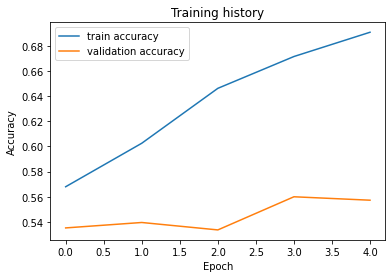

In [21]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [22]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.5572467060427079

In [23]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [24]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred,zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.4489    0.1681    0.2446       470
           1     0.4072    0.4004    0.4038       477
           2     0.7304    0.8504    0.7858      2546
           3     0.0000    0.0000    0.0000       244
           4     0.0963    0.0271    0.0423       665
           5     0.0000    0.0000    0.0000         0

    accuracy                         0.5572      4402
   macro avg     0.2805    0.2410    0.2461      4402
weighted avg     0.5291    0.5572    0.5308      4402

